## TSST: A Novel Interpretable Method for Prompt Classification of Time Series
full code with Dataset

### Load all the required libraries

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, cohen_kappa_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import graphviz
from fuzzywuzzy import process
from itertools import combinations
from aeon.distances import distance as aeon_distance
from aeon.distances import pairwise_distance as aeon_pairwise_distance
from aeon.datasets import load_from_tsfile_to_dataframe
from collections import Counter
from aeon.datasets import load_from_tsfile
from IPython.display import display
import os
from scipy.io import arff
from pycatch22 import catch22_all  #!pip install pycatch22
from scipy.spatial.distance import euclidean

### Load and split the Univariate dataset for the model (Insert the dataset's name)

In [2]:
# Load the dataset names from the file
file_path = 'Data/DataSummary.csv'
dataset_df = pd.read_csv(file_path)

# Extract dataset names from the "Name" column
dataset_names = dataset_df['Name'].tolist()

# Function to load the dataset based on the provided dataset name
def load_dataset(dataset_name):
    try:
        train_path = f'Data/{dataset_name}/{dataset_name}_TRAIN.tsv'
        test_path = f'Data/{dataset_name}/{dataset_name}_TEST.tsv'
        
        # Load training and test data
        train_data = pd.read_csv(train_path, header=None, sep='\t')
        test_data = pd.read_csv(test_path, header=None, sep='\t')
        
        print(f"{dataset_name} training data shape: {train_data.shape}")
        print(f"{dataset_name} test data shape: {test_data.shape}")
        
        return train_data, test_data
    except FileNotFoundError:
        raise ValueError(f"Error: Dataset '{dataset_name}' could not be loaded. Please check the dataset name.")

# Function to check dataset validity and suggest nearest valid dataset name if not found
def check_dataset_name(dataset_name, valid_names):
    if dataset_name in valid_names:
        return dataset_name
    else:
        # Find the closest matching dataset name using fuzzy matching
        closest_match, match_score = process.extractOne(dataset_name, valid_names)
        if match_score > 60:  # Suggest if the similarity score is reasonable
            print(f"Error: Dataset '{dataset_name}' not found. Did you mean '{closest_match}'?")
        else:
            print(f"Error: Dataset '{dataset_name}' not found and no close match available.")
        return None

# Function to calculate the number of trees for a Random Forest based on dataset size
def calculate_number_of_trees(num_training_samples):

    # Constants to adjust based on experimentation
    min_trees = 200
    max_trees = 1000
    factor = 7  # <<<--- <<<--- Proportional factor for tree <<<--- <<<---
    # Calculate initial number of trees
    number_of_trees = num_training_samples * factor
    number_of_trees = max(min_trees, min(number_of_trees, max_trees))

    return number_of_trees

# General Rule for max_depth based on dataset size
def calculate_max_depth(num_training_samples):

    min_depth = 7
    max_depth_limit = 40  # Upper limit to prevent overfitting

    # Depth based on log2 of the number of samples
    depth_samples = int(math.log2(num_training_samples)) if num_training_samples > 1 else 1

    # Ensure the depth is within set bounds
    max_depth = max(min_depth, min(depth_samples, max_depth_limit))

    return max_depth

# Function to calculate min_samples_leaf based on a small percentage of the dataset size
def calculate_min_samples_leaf(num_training_samples, percentage=0.025):

    # Ensure the percentage is within a reasonable range (1% to 5%)
    percentage = max(0.01, min(percentage, 0.05))

    # Calculate min_samples_leaf
    min_samples_leaf = max(1, int(num_training_samples * percentage))

    return min_samples_leaf

# Select the dataset (input from user)
dataset = 'InsectEPGSmallTrain'  # typo will be corrected  <<<--- <<<--- INSERT DATASET'S NAME <<<--- <<<---

# Check if the dataset name is valid
valid_dataset_name = check_dataset_name(dataset, dataset_names)

if valid_dataset_name:
    # Load the training and test data
    train_data, test_data = load_dataset(valid_dataset_name)

    # Separate features and target for training and test sets
    X_train_full = train_data.iloc[:, 1:].values
    Y_train_full = train_data.iloc[:, 0].values
    X_test = test_data.iloc[:, 1:].values
    Y_test = test_data.iloc[:, 0].values

    # Print the number of unique classes in the training data
    n_classes = len(set(Y_train_full))
    print(f"Number of classes in {valid_dataset_name}: {n_classes}")

    # Split the training data into training and validation sets (15% for validation)
    X_train, X_validation, Y_train, Y_validation = train_test_split(
        X_train_full, Y_train_full, test_size=0.15, random_state=42, stratify=Y_train_full
    )
    
    num_training_samples = X_train.shape[0]
    num_features = min([len(row[~pd.isnull(row)]) for row in X_train])  # Length of the Shortest TS in the training set  
    maxstep = math.ceil(num_features * 0.40)
    stepsize = math.ceil(num_features * 0.10)

    # Check the sizes of each set
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_validation.shape}")
    print(f"Test set shape: {X_test.shape}")

    # Calculate and print 40% and 10% of the training data length, rounded up
    print(f"length of the shortest TS: {num_features}")
    print(f"40% of the training data length for maxstep: {maxstep}")
    print(f"10% of the training data length for stepsize: {stepsize}")

    # Calculate the recommended number of trees
    relative_n_of_trees = calculate_number_of_trees(num_training_samples)
    print("Recommended number of trees:", relative_n_of_trees)


    relative_max_depth = calculate_max_depth(num_training_samples)
    print("Recommended max_depth:", relative_max_depth)

    relative_min_samples_leaf = calculate_min_samples_leaf(num_training_samples, percentage=0.01)
    print("Recommended min_samples_leaf:", relative_min_samples_leaf)

InsectEPGSmallTrain training data shape: (17, 602)
InsectEPGSmallTrain test data shape: (249, 602)
Number of classes in InsectEPGSmallTrain: 3
Training set shape: (14, 601)
Validation set shape: (3, 601)
Test set shape: (249, 601)
length of the shortest TS: 601
40% of the training data length for maxstep: 241
10% of the training data length for stepsize: 61
Recommended number of trees: 200
Recommended max_depth: 7
Recommended min_samples_leaf: 1


## TSST: Time Series Step Tree

Minimum steps: 61
Median steps: 213.5
Maximum steps: 305
Standard deviation of steps: 90.93


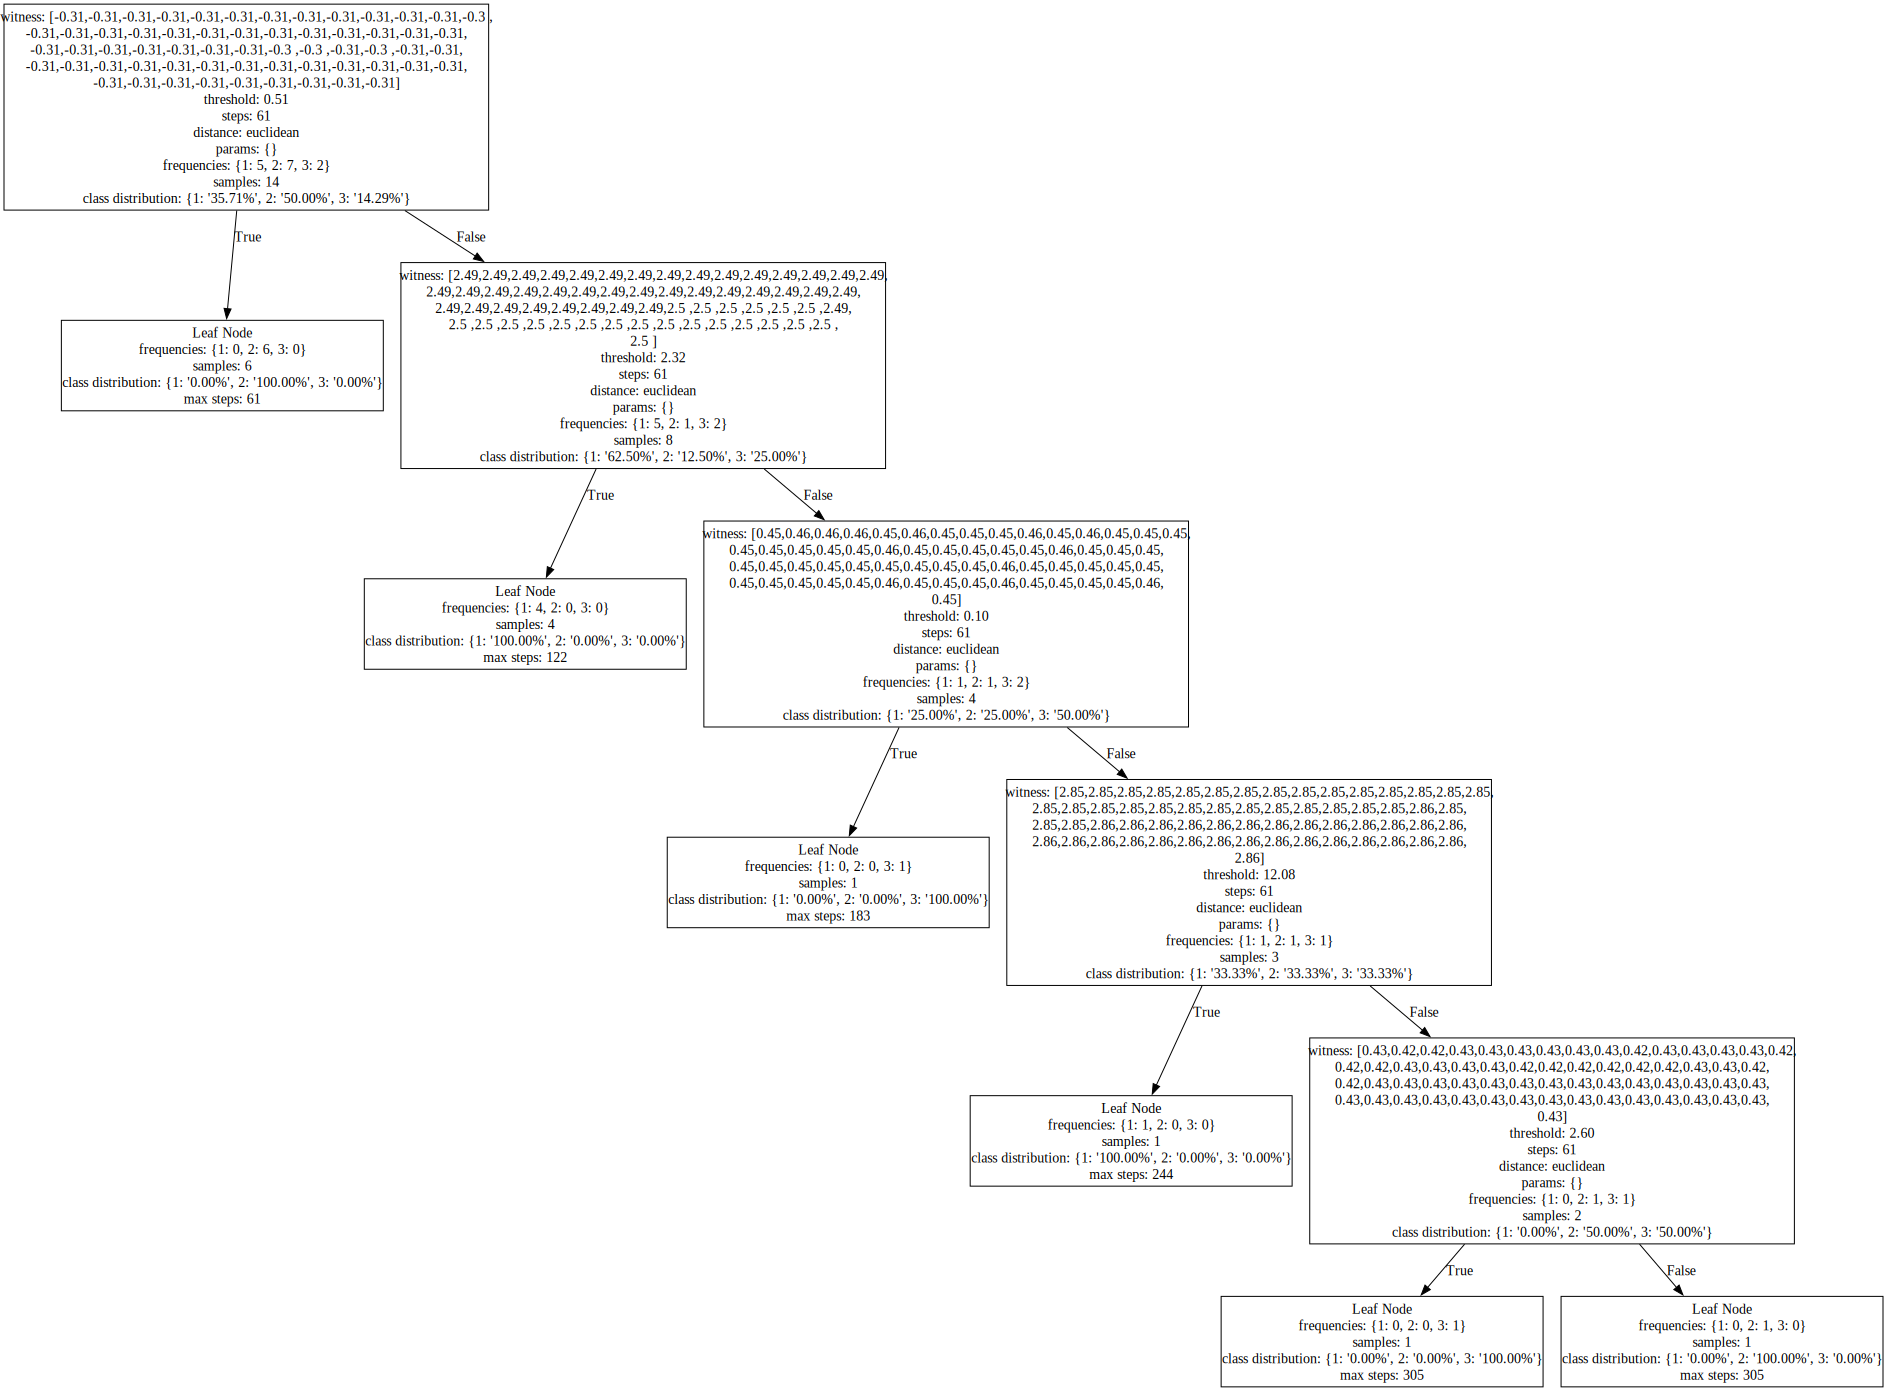

In [3]:
# Define the Node class
class Node:
    def __init__(self, witness, threshold, steps, class_distribution, all_classes,
                 distance_metric=None, distance_params=None, total_steps=0):
        self.witness = witness
        self.threshold = threshold
        self.steps = steps
        self.total_steps = total_steps  # Store the total steps taken to reach this node
        self.distance_metric = distance_metric  # Store the selected distance metric
        self.distance_params = distance_params  # Store the selected distance parameters
        self.class_distribution = self.calculate_probabilities(class_distribution, all_classes)
        self.probabilities = self.class_distribution
        self.samples = sum(class_distribution.values())
        self.raw_class_distribution = {k: class_distribution.get(k, 0) for k in all_classes}
        self.TrueChild = None
        self.FalseChild = None
        # Attributes for pruning
        self.is_leaf = False
        self.validation_class_distribution = {}
        self.validation_samples = 0
        self.static_error_rate = None
        self.backed_up_error_rate = None
        self.pruned = False

    def calculate_probabilities(self, class_distribution, all_classes):
        total = sum(class_distribution.values())
        probabilities = {k: class_distribution.get(k, 0) / total if total > 0 else 0 for k in all_classes}
        return probabilities

# Function for calculating the loss using entropy
def InformationGain(group1, group2):
    # Compute the entropy of a group
    def entropy(group):
        _, counts = np.unique(group, return_counts=True)
        probs = counts / len(group)
        return -sum(p * np.log2(p) for p in probs if p > 0)

    # Compute the information gain
    total_len = len(group1) + len(group2)
    entropy_before = entropy(np.concatenate((group1, group2)))
    entropy_after = (len(group1) * entropy(group1) + len(group2) * entropy(group2)) / total_len
    return entropy_before - entropy_after

# Function to calculate estimated error rates and perform pruning
def post_prune_tree(node, all_classes):
    if node.is_leaf:
        # Calculate estimated error rate for leaf node
        if node.validation_class_distribution:
            majority_class_count = node.validation_class_distribution.get(
                max(node.validation_class_distribution, key=node.validation_class_distribution.get, default=None), 0
            )
        else:
            majority_class_count = 0
        total = node.validation_samples
        if total > 0:
            node.static_error_rate = 1 - (majority_class_count / total)
        else:
            node.static_error_rate = 0  # No validation samples reached this node
        node.backed_up_error_rate = node.static_error_rate
    else:
        # Recursively prune child nodes
        post_prune_tree(node.TrueChild, all_classes)
        post_prune_tree(node.FalseChild, all_classes)
        # Calculate static error rate if we prune this node
        if node.validation_class_distribution:
            majority_class_count = node.validation_class_distribution.get(
                max(node.validation_class_distribution, key=node.validation_class_distribution.get, default=None), 0
            )
        else:
            majority_class_count = 0
        total = node.validation_samples
        if total > 0:
            node.static_error_rate = 1 - (majority_class_count / total)
        else:
            node.static_error_rate = 0  # No validation samples reached this node
        # Calculate backed-up error rate from children
        true_child = node.TrueChild
        false_child = node.FalseChild
        total_children = true_child.validation_samples + false_child.validation_samples
        if total_children > 0:
            node.backed_up_error_rate = (
                (true_child.validation_samples / total_children) * true_child.backed_up_error_rate +
                (false_child.validation_samples / total_children) * false_child.backed_up_error_rate
            )
        else:
            node.backed_up_error_rate = 0  # No validation samples in children
        # Decide whether to prune
        if node.static_error_rate <= node.backed_up_error_rate:
            # Prune the subtree
            node.TrueChild = None
            node.FalseChild = None
            node.is_leaf = True
            node.pruned = True
            node.backed_up_error_rate = node.static_error_rate
        else:
            node.pruned = False
            node.backed_up_error_rate = node.backed_up_error_rate

# Main training function for the tree model
def TS_Step_Tree_Train(X, Y, X_val, Y_val, maxstep, stepsize, maxd, mins, all_classes,
                       distance_functions,
                       allow_step_reuse=True, post_pruning=True, total_steps=0):
    def frequencies(Y):
        unique, counts = np.unique(Y, return_counts=True)
        return dict(zip(unique, counts))

    if len(set(Y)) == 1 or maxd == 0 or len(X) < mins or min(len(ts) for ts in X) < stepsize:
        node = Node(None, None, None, frequencies(Y), all_classes, total_steps=total_steps)
        node.is_leaf = True
        # Assign validation data to the leaf node
        node.validation_class_distribution = frequencies(Y_val)
        node.validation_samples = len(Y_val)
    else:
        real_maxstep = min(maxstep, min(len(ts) for ts in X))
        i = 1
        bestIg = 0
        best_witness = None
        best_threshold = None
        best_steps = None
        best_distance_metric = None
        best_distance_params = None
        while i * stepsize <= real_maxstep:
            X_subset = np.ascontiguousarray(X[:, 0:i * stepsize])
            # Find the best witness and split using different distance functions
            Ig, witness, threshold, distance_metric, distance_params = Find_Witness(
                X_subset, Y, distance_functions
            )
            if bestIg < Ig:
                bestIg = Ig
                best_witness = witness
                best_threshold = threshold
                best_steps = i * stepsize
                best_distance_metric = distance_metric
                best_distance_params = distance_params
            i += 1

        if bestIg == 0:
            node = Node(None, None, None, frequencies(Y), all_classes, total_steps=total_steps)
            node.is_leaf = True
            # Assign validation data to the leaf node
            node.validation_class_distribution = frequencies(Y_val)
            node.validation_samples = len(Y_val)
        else:
            node = Node(best_witness, best_threshold, best_steps, frequencies(Y), all_classes,
                        distance_metric=best_distance_metric, distance_params=best_distance_params,
                        total_steps=total_steps + best_steps)
            # Split the training data
            TrueIndexes = [i for i in range(len(X)) if aeon_distance(
                np.ascontiguousarray(best_witness),
                np.ascontiguousarray(X[i, 0:best_steps]),
                metric=best_distance_metric,
                **best_distance_params
            ) <= best_threshold]
            FalseIndexes = [i for i in range(len(X)) if i not in TrueIndexes]
            # Split the validation data
            TrueValIndexes = [i for i in range(len(X_val)) if aeon_distance(
                np.ascontiguousarray(best_witness),
                np.ascontiguousarray(X_val[i, 0:best_steps]),
                metric=best_distance_metric,
                **best_distance_params
            ) <= best_threshold]
            FalseValIndexes = [i for i in range(len(X_val)) if i not in TrueValIndexes]
            # Recursive calls for children
            node.TrueChild = TS_Step_Tree_Train(
                np.ascontiguousarray(X[TrueIndexes, best_steps + 1:]),
                Y[TrueIndexes],
                np.ascontiguousarray(X_val[TrueValIndexes, best_steps + 1:]),
                Y_val[TrueValIndexes],
                maxstep, stepsize, maxd - 1, mins, all_classes,
                distance_functions,
                allow_step_reuse, post_pruning=False,
                total_steps=node.total_steps
            )
            if allow_step_reuse:
                node.FalseChild = TS_Step_Tree_Train(
                    np.ascontiguousarray(X[FalseIndexes, :]),
                    Y[FalseIndexes],
                    np.ascontiguousarray(X_val[FalseValIndexes, :]),
                    Y_val[FalseValIndexes],
                    maxstep, stepsize, maxd - 1, mins, all_classes,
                    distance_functions,
                    allow_step_reuse, post_pruning=False,
                    total_steps=node.total_steps
                )
            else:
                node.FalseChild = TS_Step_Tree_Train(
                    np.ascontiguousarray(X[FalseIndexes, best_steps + 1:]),
                    Y[FalseIndexes],
                    np.ascontiguousarray(X_val[FalseValIndexes, best_steps + 1:]),
                    Y_val[FalseValIndexes],
                    maxstep, stepsize, maxd - 1, mins, all_classes,
                    distance_functions,
                    allow_step_reuse, post_pruning=False,
                    total_steps=node.total_steps
                )
            # Assign validation data to the node
            node.validation_class_distribution = frequencies(Y_val)
            node.validation_samples = len(Y_val)

    # Perform post-pruning if enabled
    if post_pruning:
        post_prune_tree(node, all_classes)

    return node

def Find_Witness(X_subset, Y, distance_functions):
    max_loss = 0
    best_witness = None
    best_threshold = None
    best_distance_metric = None
    best_distance_params = None

    for dist_func in distance_functions:
        metric = dist_func['metric']
        param_grid = dist_func.get('params', [{}])  # Default to [{}] if no params

        for params in param_grid:
            try:
                DM = aeon_pairwise_distance(X_subset, metric=metric, **params)
            except Exception as e:
                print(f"Error computing distances with metric {metric} and params {params}: {e}")
                continue
            for i in range(len(X_subset)):
                value, threshold = best_cut(i, Y, DM, InformationGain)
                if value > max_loss:
                    max_loss = value
                    best_witness = X_subset[i]
                    best_threshold = threshold
                    best_distance_metric = metric
                    best_distance_params = params

    return max_loss, best_witness, best_threshold, best_distance_metric, best_distance_params

def best_cut(idx, Y, DM, Loss):
    pairs = [(DM[j, idx], Y[j]) for j in range(len(Y))]
    pairs.sort(key=lambda x: x[0])
    if len(pairs) < 2:
        return 0, 0  # Cannot split
    loss_values = [Loss(
        np.array([p[1] for p in pairs[:j]]),
        np.array([p[1] for p in pairs[j:]])
    ) for j in range(1, len(Y))]
    j = np.argmax(loss_values)
    threshold = (pairs[j][0] + pairs[j - 1][0]) / 2

    return loss_values[j], threshold

def predict(node, x):
    if node.witness is None or node.is_leaf:
        return node.probabilities
    distance_metric = node.distance_metric
    distance_params = node.distance_params if node.distance_params else {}
    distance = aeon_distance(
        np.ascontiguousarray(node.witness),
        np.ascontiguousarray(x[0:node.steps]),
        metric=distance_metric,
        **distance_params
    )
    if distance <= node.threshold:
        if node.TrueChild is not None:
            return predict(node.TrueChild, x[node.steps:])
        else:
            return node.probabilities
    else:
        if node.FalseChild is not None:
            return predict(node.FalseChild, x[node.steps:])
        else:
            return node.probabilities
# New function to later calculate min, max, median and std of steps in leaf nodes
def collect_leaf_steps(node, steps_list):
    if node.is_leaf:
        if node.total_steps is not None:
            steps_list.append(node.total_steps)
    else:
        if node.TrueChild:
            collect_leaf_steps(node.TrueChild, steps_list)
        if node.FalseChild:
            collect_leaf_steps(node.FalseChild, steps_list)

# Visualize the tree using graphviz, highlighting pruned nodes in red and showing additional new statistics
def visualize_step_tree(node, all_classes, dot=None, root_steps=None):
    if dot is None:
        dot = graphviz.Digraph()
        root_steps = node.steps if node.steps is not None else 0

    steps_list = []
    collect_leaf_steps(node, steps_list)

    # Calculate the overall max steps
    overall_max_steps = max(steps_list) if steps_list else root_steps

    if node.is_leaf:
        if not node.class_distribution:
            node_label = 'Leaf Node\nNo Data'
        else:
            total = sum(node.raw_class_distribution.values())
            class_distribution = {k: (node.raw_class_distribution.get(k, 0) / total) * 100 for k in all_classes}
            max_steps = node.total_steps
            node_label = 'Leaf Node\nfrequencies: {}\nsamples: {}\nclass distribution: {}\nmax steps: {}'.format(
                node.raw_class_distribution,
                node.samples,
                {k: f'{v:.2f}%' for k, v in class_distribution.items()},
                max_steps
            )
    else:
        total = sum(node.raw_class_distribution.values())
        class_distribution = {k: (node.raw_class_distribution.get(k, 0) / total) * 100 for k in all_classes}
        # Convert witness to string with limited length to avoid clutter
        witness_str = np.array2string(node.witness, precision=2, separator=',', suppress_small=True, max_line_width=80)
        node_label = 'witness: {}\nthreshold: {:.2f}\nsteps: {}\ndistance: {}\nparams: {}\nfrequencies: {}\nsamples: {}\nclass distribution: {}'.format(
            witness_str,
            node.threshold,
            node.steps,
            node.distance_metric,
            node.distance_params,
            node.raw_class_distribution,
            node.samples,
            {k: f'{v:.2f}%' for k, v in class_distribution.items()}
        )

    # Highlight pruned nodes in red
    if node.pruned:
        dot.node(str(id(node)), label=node_label, color='red', shape='box')
    else:
        dot.node(str(id(node)), label=node_label, shape='box')

    if not node.is_leaf:
        if node.TrueChild:
            dot.edge(str(id(node)), str(id(node.TrueChild)), label='True')
            visualize_step_tree(node.TrueChild, all_classes, dot, root_steps)
        if node.FalseChild:
            dot.edge(str(id(node)), str(id(node.FalseChild)), label='False')
            visualize_step_tree(node.FalseChild, all_classes, dot, root_steps)
    return dot

# Training usage 
maxstep = maxstep
stepsize = stepsize
maxd = relative_max_depth
mins = relative_min_samples_leaf

# Combine all classes from training and validation sets
all_classes = np.unique(np.concatenate((Y_train, Y_validation)))

# Define the distance functions and parameter grids to test
distance_functions = [
    {'metric': 'euclidean', 'params': [{}]},
    {'metric': 'manhattan', 'params': [{}]},
    {'metric': 'squared', 'params': [{}]},
    {'metric': 'minkowski', 'params': [{'p': 1.0}, {'p': 3.0}]},
    {'metric': 'dtw', 'params': [{'window': None}, {'window': 0}, {'window': 0.25}, {'window': 0.5}, {'window': 0.75}, {'window': 1.0}, {'itakura_max_slope': None}, {'itakura_max_slope': 0.5}, {'itakura_max_slope': 1.0}]},
    {'metric': 'ddtw', 'params': [{'window': None}, {'window': 0}, {'window': 0.25}, {'window': 0.5}, {'window': 0.75}, {'window': 1.0}, {'itakura_max_slope': None}, {'itakura_max_slope': 0.5}, {'itakura_max_slope': 1.0}]},
    {'metric': 'wdtw', 'params': [{'g': 0.05}, {'g': 0.1}, {'g': 0.25}, {'itakura_max_slope': None}, {'itakura_max_slope': 0.5}, {'itakura_max_slope': 1.0}]},
    {'metric': 'wddtw', 'params': [{'g': 0.05}, {'g': 0.1}, {'g': 0.25}, {'itakura_max_slope': None}, {'itakura_max_slope': 0.5}, {'itakura_max_slope': 1.0}]},
    {'metric': 'lcss', 'params': [{'epsilon': 0.5}, {'epsilon': 1.0}, {'epsilon': 1.75}, {'epsilon': 3}]},
    {'metric': 'edr', 'params': [{'epsilon': 0.5}, {'epsilon': 1.0}, {'epsilon': 1.75}, {'epsilon': 3}]},
    {'metric': 'erp', 'params': [{'g': 0.0}, {'g': 0.5}, {'g': 1.0}]},
    {'metric': 'msm', 'params': [{'c': 0.01}, {'c': 0.1}, {'c': 1.0}, {'independent': True}, {'independent': False}]},
    {'metric': 'twe', 'params': [{'nu': 0.001, 'lambda': 1.0}, {'nu': 0.001, 'lambda': 1.5}, {'nu': 0.001, 'lambda': 2.0}]},
    {'metric': 'adtw', 'params': [{'warp_penalty': 0.5}, {'warp_penalty': 1.0}, {'warp_penalty': 2.0}]},
    {'metric': 'sbd', 'params': [{'standardize': True}, {'standardize': False}]},
    {'metric': 'shape_dtw', 'params': [{'reach': 10}, {'reach': 30}, {'reach': 50},
    ]}
]

# Train the model with validation data and post-pruning option
train_example = TS_Step_Tree_Train(
    X_train, Y_train, X_validation, Y_validation,
    maxstep, stepsize, maxd, mins,
    all_classes, distance_functions,
    allow_step_reuse=True, post_pruning=True
)

# Collect the steps from all leaf nodes
steps_list = []
collect_leaf_steps(train_example, steps_list)

# Calculate the statistics
min_steps = min(steps_list) if steps_list else 0
max_steps = max(steps_list) if steps_list else 0
median_steps = np.median(steps_list) if steps_list else 0
std_steps = np.std(steps_list) if steps_list else 0

# Print the statistics
print(f"Minimum steps: {min_steps}")
print(f"Median steps: {median_steps}")
print(f"Maximum steps: {max_steps}")
print(f"Standard deviation of steps: {std_steps:.2f}")

# Visualize the pruned tree
dot = visualize_step_tree(train_example, all_classes)
dot.render(f'{dataset}_ts_step_tree', format='pdf', cleanup=True)
dot

## Evaluation metrics and ROC curve for Univariate tree

Overall Accuracy on test set: 100.00

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00       118
           3       1.00      1.00      1.00        42

    accuracy                           1.00       249
   macro avg       1.00      1.00      1.00       249
weighted avg       1.00      1.00      1.00       249

Cohen's Kappa: 1.00
Matthews Correlation Coefficient (MCC): 1.00

Per-Class Metrics:
   Precision  Recall  F1-Score  Accuracy  Cohen's Kappa  MCC
1        1.0     1.0       1.0       1.0            1.0  1.0
2        1.0     1.0       1.0       1.0            1.0  1.0
3        1.0     1.0       1.0       1.0            1.0  1.0


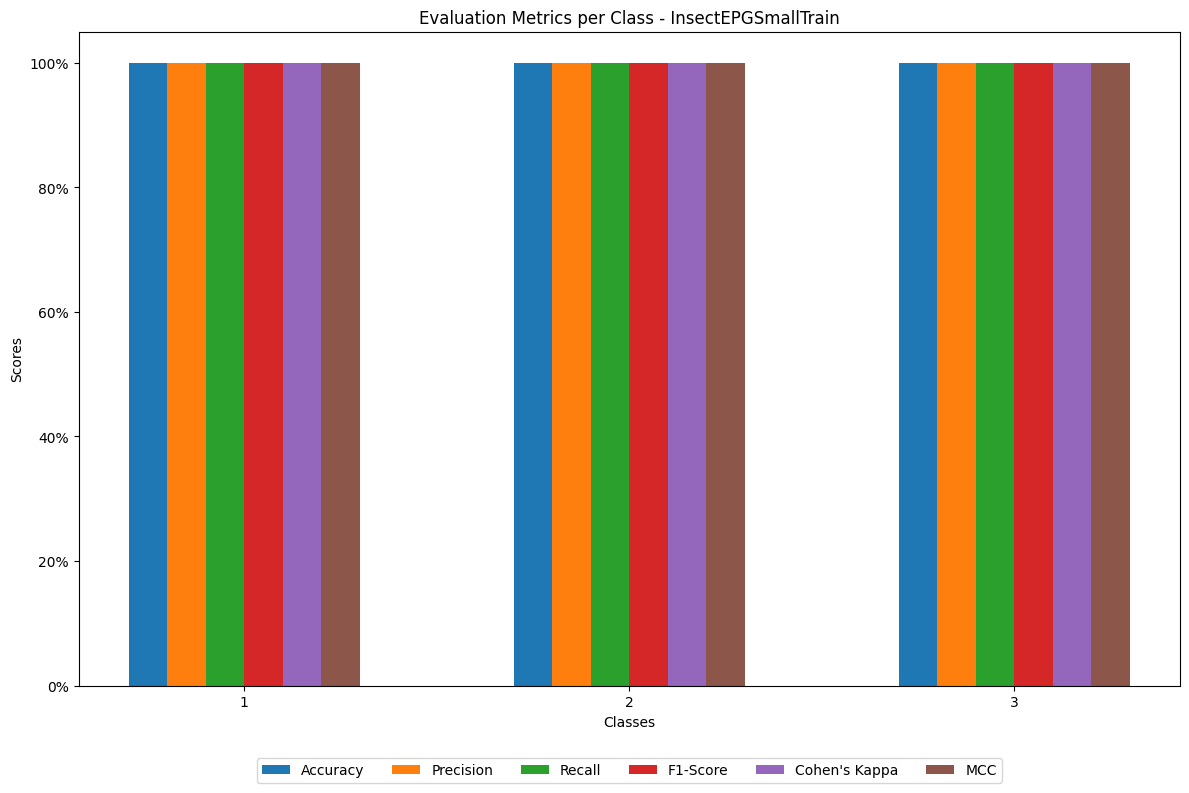

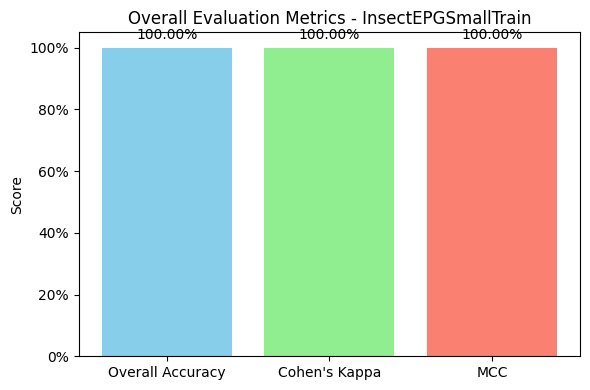

One-vs-Rest (OvR) Scheme


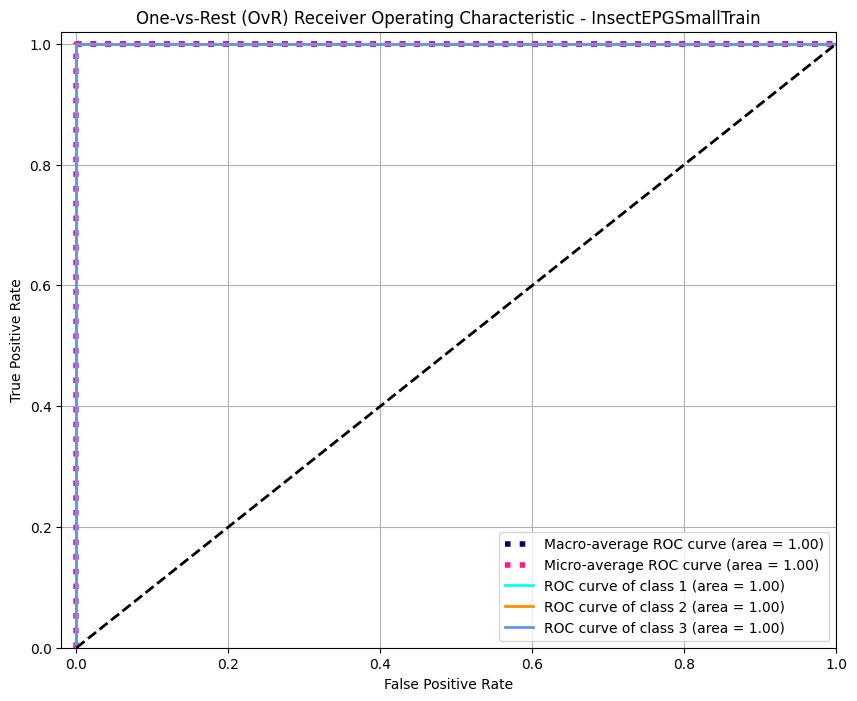

One-vs-One (OvO) Scheme


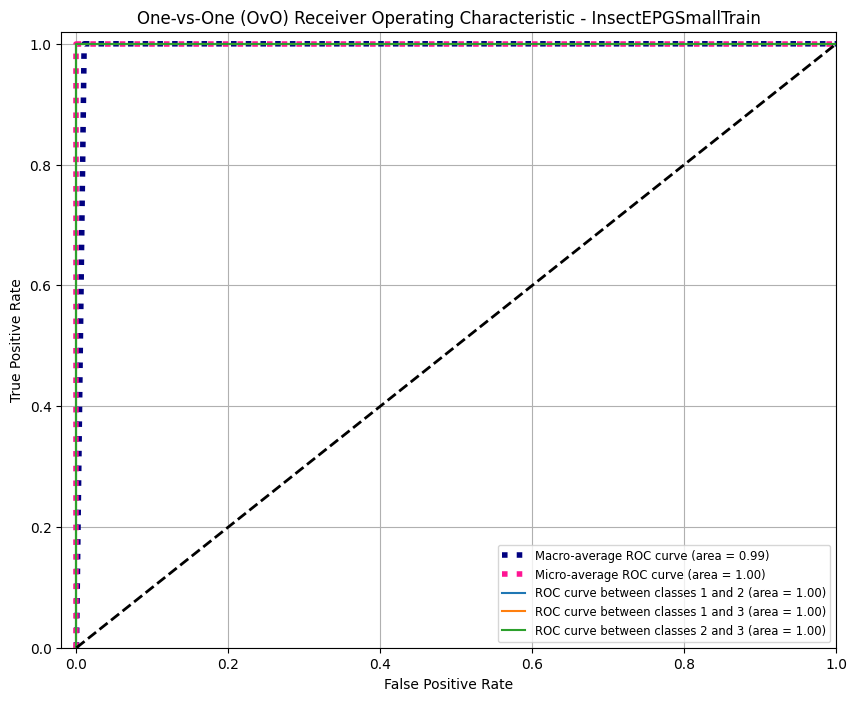

In [4]:
# Evaluate the tree on the test set
def evaluate_model(node, X_test, Y_test, class_names):
    correct = 0
    total = len(Y_test)
    y_true = []
    y_pred = []
    for x, y_t in zip(X_test, Y_test):
        probabilities = predict(node, x)
        y_p = max(probabilities, key=probabilities.get)
        y_true.append(y_t)
        y_pred.append(y_p)
        if y_p == y_t:
            correct += 1
    accuracy = correct / total
    print(f"Overall Accuracy on test set: {accuracy * 100:.2f}")
    
    # Generate classification report
    report = classification_report(y_true, y_pred, labels=class_names, output_dict=True, zero_division='warn')
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=class_names, zero_division='warn'))
    
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa:.2f}")
    
    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")
    
    # Calculate per-class accuracy
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    # Prepare data for visualization
    metrics_df = pd.DataFrame(index=class_names)
    metrics_df['Precision'] = [report[str(cls)]['precision'] for cls in class_names]
    metrics_df['Recall'] = [report[str(cls)]['recall'] for cls in class_names]
    metrics_df['F1-Score'] = [report[str(cls)]['f1-score'] for cls in class_names]
    metrics_df['Accuracy'] = per_class_accuracy
    # Kappa and MCC are overall metrics; we can replicate them for each class for visualization purposes
    metrics_df["Cohen's Kappa"] = kappa
    metrics_df['MCC'] = mcc
    
    # Display the DataFrame
    print("\nPer-Class Metrics:")
    print(metrics_df)
    
    # Plot the metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', "Cohen's Kappa", 'MCC']
    num_metrics = len(metrics)
    num_classes = len(class_names)
    bar_width = 0.1
    index = np.arange(num_classes)
    
    plt.figure(figsize=(12, 8))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, metrics_df[metric], bar_width, label=metric)
    
    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title(f'Evaluation Metrics per Class - {dataset}')
    plt.xticks(index + bar_width * (num_metrics - 1) / 2, class_names)
    plt.ylim(0, 1.05)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=num_metrics)
    
    # Format y-axis as percentages
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y * 100)}%'))
    
    plt.tight_layout()
    plt.savefig(f'{dataset}_evaluation_metrics_per_class.pdf')
    plt.show()
    
    # Also, plot overall metrics separately if desired
    overall_metrics = {
        'Overall Accuracy': accuracy,
        "Cohen's Kappa": kappa,
        'MCC': mcc
    }
    plt.figure(figsize=(6, 4))
    bars = plt.bar(overall_metrics.keys(), overall_metrics.values(), color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylabel('Score')
    plt.title(f'Overall Evaluation Metrics - {dataset}')
    plt.ylim(0, 1.05)
    
    # Adding the scores on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval * 100:.2f}%', ha='center', va='bottom')
    
    # Format y-axis as percentages
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y * 100)}%'))
    
    plt.tight_layout()
    plt.savefig(f'{dataset}_overall_evaluation_metrics.pdf')
    plt.show()

# Define class names (labels)
class_names = sorted(np.unique(np.concatenate((Y_train, Y_validation, Y_test))))

# Call the function to evaluate the model and plot the metrics
evaluate_model(train_example, X_test, Y_test, class_names)

####################<<<ROC CURVES>>>###################
# 'all_classes', 'train_example', 'X_test', 'Y_test', and 'predict' must be defined.

# Combine all classes from training, validation, and test sets
all_classes = np.unique(np.concatenate((Y_train, Y_validation, Y_test)))
n_classes = len(all_classes)

# Ensure that 'all_classes' is sorted to maintain consistent ordering
all_classes = np.sort(all_classes)

# Binarize the labels
if n_classes == 2:
    # Manually create a binary label matrix with two columns for binary classification
    Y_test_bin = np.zeros((len(Y_test), n_classes))
    for i, class_label in enumerate(all_classes):
        Y_test_bin[:, i] = (Y_test == class_label).astype(int)
else:
    # For multiclass classification
    Y_test_bin = label_binarize(Y_test, classes=all_classes)

# Generate predictions for the test data
probabilities_train_example = []
for x in X_test:
    prob = predict(train_example, x)
    # Ensure the probabilities are in the same order as 'all_classes'
    probabilities = [prob.get(cls, 0) for cls in all_classes]
    probabilities_train_example.append(probabilities)

# Convert probabilities to a 2D array
probabilities_train_example = np.array(probabilities_train_example)

# One-vs-Rest (OvR) Scheme
print("One-vs-Rest (OvR) Scheme")

# Initialize dictionaries to hold fpr, tpr, and roc_auc for each class
fpr_ovr = dict()
tpr_ovr = dict()
roc_auc_ovr = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr_ovr[i], tpr_ovr[i], _ = roc_curve(Y_test_bin[:, i], probabilities_train_example[:, i])
    roc_auc_ovr[i] = auc(fpr_ovr[i], tpr_ovr[i])

# Compute micro-average ROC curve and ROC area
fpr_ovr["micro"], tpr_ovr["micro"], _ = roc_curve(Y_test_bin.ravel(), probabilities_train_example.ravel())
roc_auc_ovr["micro"] = auc(fpr_ovr["micro"], tpr_ovr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr_ovr = np.unique(np.concatenate([fpr_ovr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr_ovr = np.zeros_like(all_fpr_ovr)
for i in range(n_classes):
    mean_tpr_ovr += np.interp(all_fpr_ovr, fpr_ovr[i], tpr_ovr[i])

# Finally average it and compute AUC
mean_tpr_ovr /= n_classes

fpr_ovr["macro"] = all_fpr_ovr
tpr_ovr["macro"] = mean_tpr_ovr
roc_auc_ovr["macro"] = auc(fpr_ovr["macro"], tpr_ovr["macro"])

# Plot all OvR ROC curves
plt.figure(figsize=(10, 8))

# Plot macro-average ROC curve
plt.plot(fpr_ovr["macro"], tpr_ovr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_ovr["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot micro-average ROC curve
plt.plot(fpr_ovr["micro"], tpr_ovr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_ovr["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curves for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'olive', 'cyan', 'magenta']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_ovr[i], tpr_ovr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(all_classes[i], roc_auc_ovr[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'One-vs-Rest (OvR) Receiver Operating Characteristic - {dataset}')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(f'{dataset}_roc_curve_ovr.pdf')
plt.show()

# One-vs-One (OvO) Scheme
if n_classes > 2:
    print("One-vs-One (OvO) Scheme")

    # Initialize lists to hold fpr, tpr, and roc_auc for each pair
    fpr_ovo = dict()
    tpr_ovo = dict()
    roc_auc_ovo = dict()

    # Generate all pairs of classes
    pair_indices = list(combinations(range(n_classes), 2))

    # Initialize lists for macro-average and micro-average computation
    tprs_ovo = []
    aucs_ovo = []
    mean_fpr_ovo = np.linspace(0, 1, 100)

    # Lists to collect all true labels and scores for micro-average
    all_true_labels = []
    all_scores = []

    for (i, j) in pair_indices:
        # Create a mask for the two classes
        mask = np.logical_or(Y_test == all_classes[i], Y_test == all_classes[j])
        Y_test_pair = Y_test[mask]
        if len(np.unique(Y_test_pair)) < 2:
            continue  # Skip if only one class is present
        Y_test_bin_pair = (Y_test_pair == all_classes[j]).astype(int)
        probabilities_pair = probabilities_train_example[mask][:, [i, j]]
        # Use probabilities for the positive class (all_classes[j])
        y_score = probabilities_pair[:, 1]
        fpr, tpr, _ = roc_curve(Y_test_bin_pair, y_score)
        roc_auc = auc(fpr, tpr)
        fpr_ovo[(i, j)] = fpr
        tpr_ovo[(i, j)] = tpr
        roc_auc_ovo[(i, j)] = roc_auc
        # Interpolate tpr at mean_fpr_ovo for macro-average
        interp_tpr = np.interp(mean_fpr_ovo, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs_ovo.append(interp_tpr)
        aucs_ovo.append(roc_auc)
        # Collect data for micro-average
        all_true_labels.extend(Y_test_bin_pair)
        all_scores.extend(y_score)

    # Compute micro-average ROC curve and ROC area
    all_true_labels = np.array(all_true_labels)
    all_scores = np.array(all_scores)
    fpr_ovo["micro"], tpr_ovo["micro"], _ = roc_curve(all_true_labels, all_scores)
    roc_auc_ovo["micro"] = auc(fpr_ovo["micro"], tpr_ovo["micro"])

    # Compute macro-average ROC curve and ROC area for OvO
    mean_tpr_ovo = np.mean(tprs_ovo, axis=0)
    mean_tpr_ovo[-1] = 1.0
    roc_auc_ovo["macro"] = auc(mean_fpr_ovo, mean_tpr_ovo)

    # Plot all OvO ROC curves
    plt.figure(figsize=(10, 8))

    # Plot macro-average ROC curve
    plt.plot(mean_fpr_ovo, mean_tpr_ovo,
             label='Macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_ovo["macro"]),
             color='navy', linestyle=':', linewidth=4)

    # Plot micro-average ROC curve
    plt.plot(fpr_ovo["micro"], tpr_ovo["micro"],
             label='Micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_ovo["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    # Plot ROC curves for each pair
    for (i, j) in pair_indices:
        if (i, j) in fpr_ovo:
            plt.plot(fpr_ovo[(i, j)], tpr_ovo[(i, j)], lw=1.5,
                     label='ROC curve between classes {0} and {1} (area = {2:0.2f})'
                     ''.format(all_classes[i], all_classes[j], roc_auc_ovo[(i, j)]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'One-vs-One (OvO) Receiver Operating Characteristic - {dataset}')
    plt.legend(loc="lower right", fontsize='small')
    plt.grid(True)
    plt.savefig(f'{dataset}_roc_curve_ovo.pdf')
    plt.show()
else:
    print("Binary classification detected. Skipping OvO plot as it's equivalent to OvR.")



## Random Forest for Univariate dataset

Training tree 1/200
Tree 1 statistics:
  Minimum steps: 61
  Median steps: 213.5
  Maximum steps: 305
  Standard deviation of steps: 90.93
Training tree 2/200
Tree 2 statistics:
  Minimum steps: 61
  Median steps: 91.5
  Maximum steps: 122
  Standard deviation of steps: 30.50
Training tree 3/200
Tree 3 statistics:
  Minimum steps: 61
  Median steps: 91.5
  Maximum steps: 122
  Standard deviation of steps: 30.50
Training tree 4/200
Tree 4 statistics:
  Minimum steps: 61
  Median steps: 152.5
  Maximum steps: 183
  Standard deviation of steps: 50.58
Training tree 5/200
Tree 5 statistics:
  Minimum steps: 122
  Median steps: 152.5
  Maximum steps: 183
  Standard deviation of steps: 30.50
Training tree 6/200
Tree 6 statistics:
  Minimum steps: 61
  Median steps: 152.5
  Maximum steps: 183
  Standard deviation of steps: 50.58
Training tree 7/200
Tree 7 statistics:
  Minimum steps: 61
  Median steps: 152.5
  Maximum steps: 244
  Standard deviation of steps: 68.20
Training tree 8/200
Tree 8 s

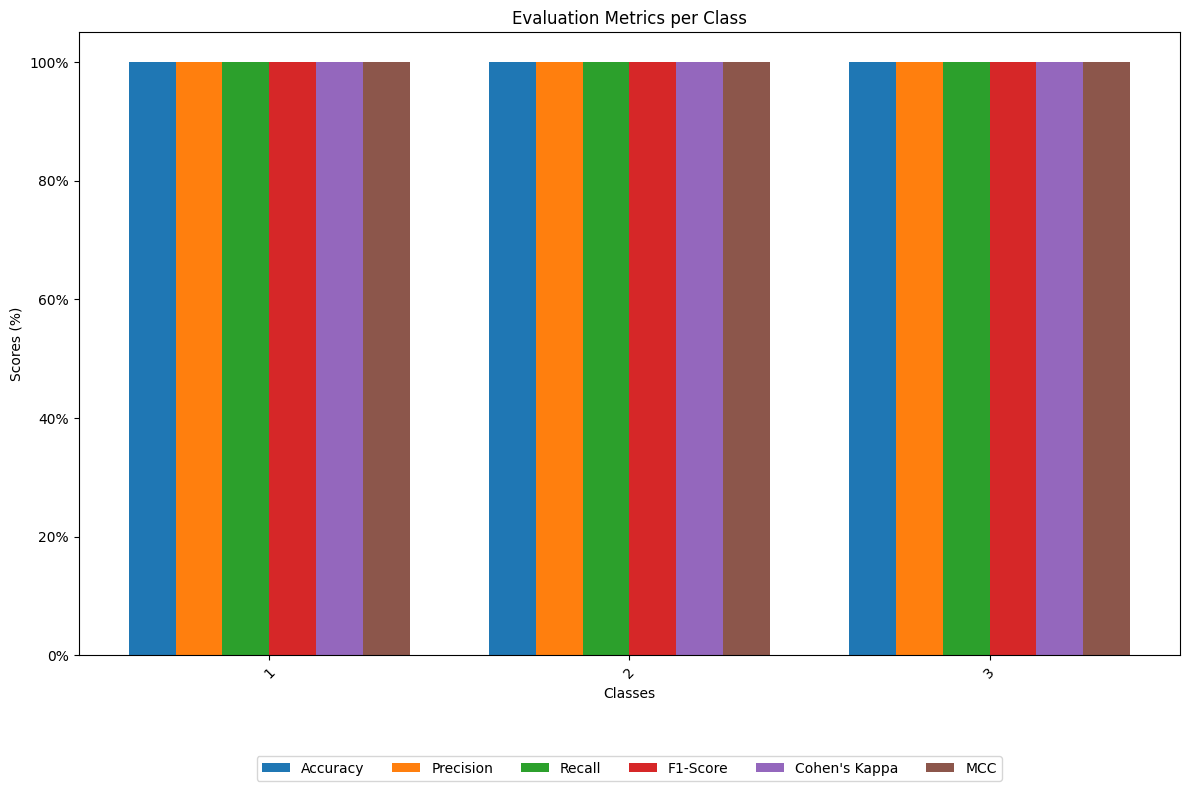

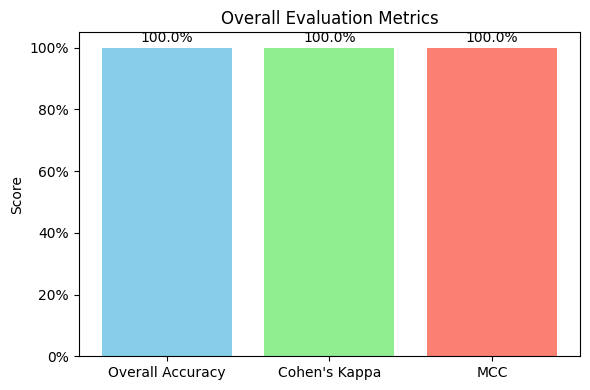

One-vs-Rest (OvR) Scheme


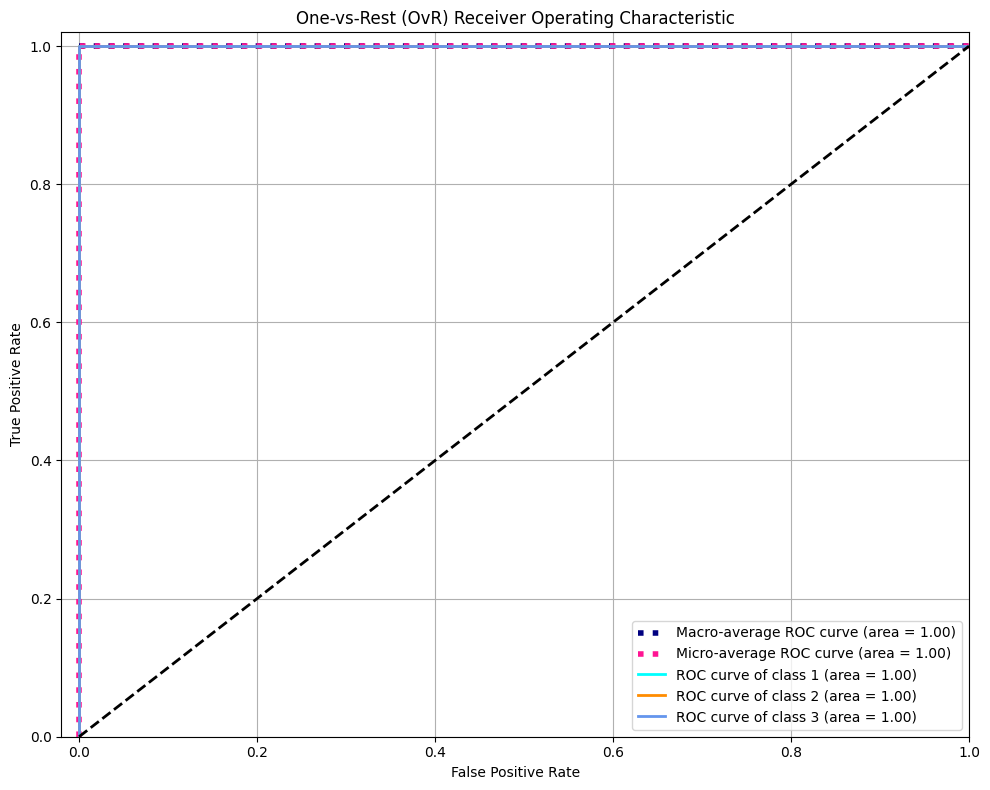

One-vs-One (OvO) Scheme


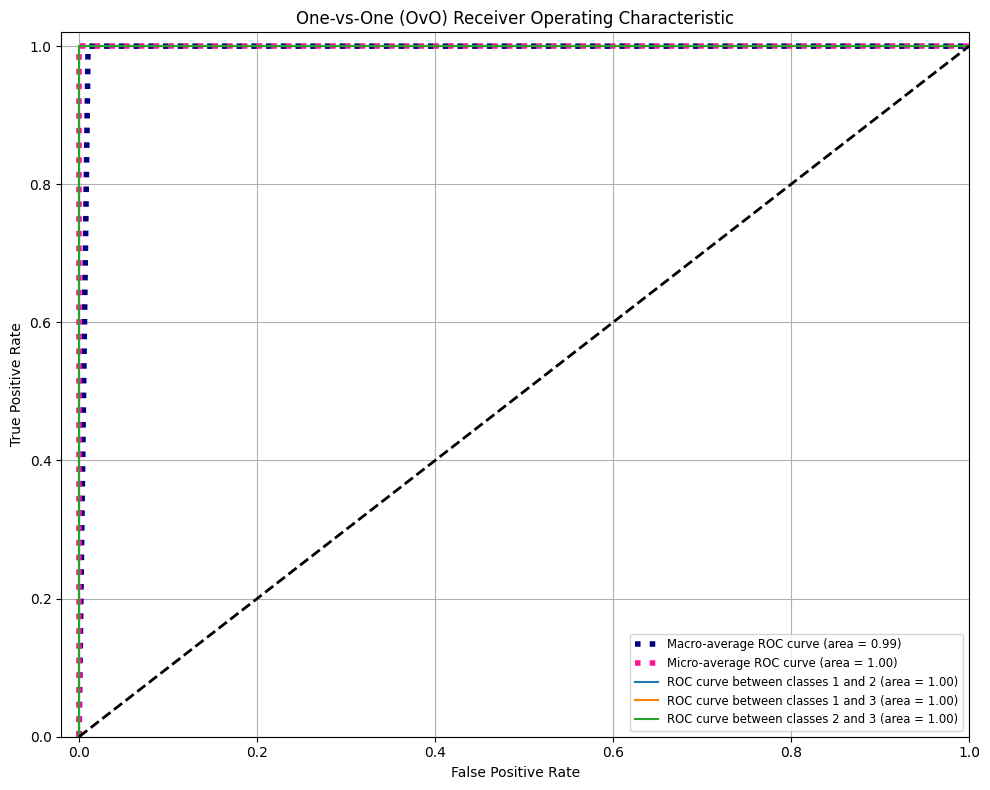

In [5]:
# Define the Node class with total_steps attribute
class Node:
    def __init__(
        self,
        witness,
        threshold,
        steps,
        class_distribution,
        all_classes,
        distance_metric=None,
        distance_params=None,
        total_steps=0,
    ):
        self.witness = witness
        self.threshold = threshold
        self.steps = steps
        self.total_steps = total_steps  # Store the total steps taken to reach this node
        self.distance_metric = distance_metric  # Store the selected distance metric
        self.distance_params = distance_params  # Store the selected distance parameters
        self.class_distribution = self.calculate_probabilities(
            class_distribution, all_classes
        )
        self.probabilities = self.class_distribution
        self.samples = sum(class_distribution.values())
        self.raw_class_distribution = {
            k: class_distribution.get(k, 0) for k in all_classes
        }
        self.TrueChild = None
        self.FalseChild = None
        # Attributes for pruning
        self.is_leaf = False
        self.validation_class_distribution = {}
        self.validation_samples = 0
        self.static_error_rate = None
        self.backed_up_error_rate = None
        self.pruned = False

    def calculate_probabilities(self, class_distribution, all_classes):
        total = sum(class_distribution.values())
        probabilities = {
            k: class_distribution.get(k, 0) / total if total > 0 else 0
            for k in all_classes
        }
        return probabilities

# Function for calculating the loss using entropy
def InformationGain(group1, group2):
    # Compute the entropy of a group
    def entropy(group):
        _, counts = np.unique(group, return_counts=True)
        probs = counts / len(group)
        return -sum(p * np.log2(p) for p in probs if p > 0)

    # Compute the information gain
    total_len = len(group1) + len(group2)
    entropy_before = entropy(np.concatenate((group1, group2)))
    entropy_after = (
        (len(group1) * entropy(group1) + len(group2) * entropy(group2)) / total_len
    )
    return entropy_before - entropy_after

# Function to calculate estimated error rates and perform pruning
def post_prune_tree(node, all_classes):
    if node.is_leaf:
        # Calculate estimated error rate for leaf node
        if node.validation_class_distribution:
            majority_class_count = node.validation_class_distribution.get(
                max(
                    node.validation_class_distribution,
                    key=node.validation_class_distribution.get,
                    default=None,
                ),
                0,
            )
        else:
            majority_class_count = 0
        total = node.validation_samples
        if total > 0:
            node.static_error_rate = 1 - (majority_class_count / total)
        else:
            node.static_error_rate = 0  # No validation samples reached this node
        node.backed_up_error_rate = node.static_error_rate
    else:
        # Recursively prune child nodes
        post_prune_tree(node.TrueChild, all_classes)
        post_prune_tree(node.FalseChild, all_classes)
        # Calculate static error rate if we prune this node
        if node.validation_class_distribution:
            majority_class_count = node.validation_class_distribution.get(
                max(
                    node.validation_class_distribution,
                    key=node.validation_class_distribution.get,
                    default=None,
                ),
                0,
            )
        else:
            majority_class_count = 0
        total = node.validation_samples
        if total > 0:
            node.static_error_rate = 1 - (majority_class_count / total)
        else:
            node.static_error_rate = 0  # No validation samples reached this node
        # Calculate backed-up error rate from children
        true_child = node.TrueChild
        false_child = node.FalseChild
        total_children = true_child.validation_samples + false_child.validation_samples
        if total_children > 0:
            node.backed_up_error_rate = (
                (true_child.validation_samples / total_children)
                * true_child.backed_up_error_rate
                + (false_child.validation_samples / total_children)
                * false_child.backed_up_error_rate
            )
        else:
            node.backed_up_error_rate = 0  # No validation samples in children
        # Decide whether to prune
        if node.static_error_rate <= node.backed_up_error_rate:
            # Prune the subtree
            node.TrueChild = None
            node.FalseChild = None
            node.is_leaf = True
            node.pruned = True
            node.backed_up_error_rate = node.static_error_rate
        else:
            node.pruned = False
            node.backed_up_error_rate = node.backed_up_error_rate

# Main training function for the tree model
def TS_Step_Tree_Train(
    X,
    Y,
    X_val,
    Y_val,
    maxstep,
    stepsize,
    maxd,
    mins,
    all_classes,
    distance_functions,
    allow_step_reuse=True,
    post_pruning=True,
    total_steps=0,
):
    def frequencies(Y):
        unique, counts = np.unique(Y, return_counts=True)
        return dict(zip(unique, counts))

    if (
        len(set(Y)) == 1
        or maxd == 0
        or len(X) < mins
        or min(len(ts) for ts in X) < stepsize
    ):
        node = Node(None, None, None, frequencies(Y), all_classes, total_steps=total_steps)
        node.is_leaf = True
        # Assign validation data to the leaf node
        node.validation_class_distribution = frequencies(Y_val)
        node.validation_samples = len(Y_val)
    else:
        real_maxstep = min(maxstep, min(len(ts) for ts in X))
        i = 1
        bestIg = 0
        best_witness = None
        best_threshold = None
        best_steps = None
        best_distance_metric = None
        best_distance_params = None
        while i * stepsize <= real_maxstep:
            X_subset = np.ascontiguousarray([ts[: i * stepsize] for ts in X])
            # Find the best witness and split using different distance functions
            Ig, witness, threshold, distance_metric, distance_params = Find_Witness(
                X_subset, Y, distance_functions
            )
            if bestIg < Ig:
                bestIg = Ig
                best_witness = witness
                best_threshold = threshold
                best_steps = i * stepsize
                best_distance_metric = distance_metric
                best_distance_params = distance_params
            i += 1

        if bestIg == 0:
            node = Node(None, None, None, frequencies(Y), all_classes, total_steps=total_steps)
            node.is_leaf = True
            # Assign validation data to the leaf node
            node.validation_class_distribution = frequencies(Y_val)
            node.validation_samples = len(Y_val)
        else:
            node = Node(
                best_witness,
                best_threshold,
                best_steps,
                frequencies(Y),
                all_classes,
                distance_metric=best_distance_metric,
                distance_params=best_distance_params,
                total_steps=total_steps + best_steps,
            )
            # Split the training data
            TrueIndexes = [
                idx
                for idx in range(len(X))
                if aeon_distance(
                    np.ascontiguousarray(best_witness),
                    np.ascontiguousarray(X[idx][: best_steps]),
                    metric=best_distance_metric,
                    **best_distance_params,
                )
                <= best_threshold
            ]
            FalseIndexes = [idx for idx in range(len(X)) if idx not in TrueIndexes]
            # Split the validation data
            TrueValIndexes = [
                idx
                for idx in range(len(X_val))
                if aeon_distance(
                    np.ascontiguousarray(best_witness),
                    np.ascontiguousarray(X_val[idx][: best_steps]),
                    metric=best_distance_metric,
                    **best_distance_params,
                )
                <= best_threshold
            ]
            FalseValIndexes = [idx for idx in range(len(X_val)) if idx not in TrueValIndexes]
            # Recursive calls for children
            node.TrueChild = TS_Step_Tree_Train(
                [X[idx][best_steps:] for idx in TrueIndexes],
                Y[TrueIndexes],
                [X_val[idx][best_steps:] for idx in TrueValIndexes],
                Y_val[TrueValIndexes],
                maxstep,
                stepsize,
                maxd - 1,
                mins,
                all_classes,
                distance_functions,
                allow_step_reuse,
                post_pruning=False,
                total_steps=node.total_steps,
            )
            if allow_step_reuse:
                node.FalseChild = TS_Step_Tree_Train(
                    [X[idx] for idx in FalseIndexes],
                    Y[FalseIndexes],
                    [X_val[idx] for idx in FalseValIndexes],
                    Y_val[FalseValIndexes],
                    maxstep,
                    stepsize,
                    maxd - 1,
                    mins,
                    all_classes,
                    distance_functions,
                    allow_step_reuse,
                    post_pruning=False,
                    total_steps=node.total_steps,
                )
            else:
                node.FalseChild = TS_Step_Tree_Train(
                    [X[idx][best_steps + 1 :] for idx in FalseIndexes],
                    Y[FalseIndexes],
                    [X_val[idx][best_steps + 1 :] for idx in FalseValIndexes],
                    Y_val[FalseValIndexes],
                    maxstep,
                    stepsize,
                    maxd - 1,
                    mins,
                    all_classes,
                    distance_functions,
                    allow_step_reuse,
                    post_pruning=False,
                    total_steps=node.total_steps,
                )
            # Assign validation data to the node
            node.validation_class_distribution = frequencies(Y_val)
            node.validation_samples = len(Y_val)

    # Perform post-pruning if enabled
    if post_pruning:
        post_prune_tree(node, all_classes)

    return node

def Find_Witness(X_subset, Y, distance_functions):
    max_loss = 0
    best_witness = None
    best_threshold = None
    best_distance_metric = None
    best_distance_params = None

    for dist_func in distance_functions:
        metric = dist_func['metric']
        param_grid = dist_func.get('params', [{}])  # Default to [{}] if no params

        for params in param_grid:
            try:
                DM = aeon_pairwise_distance(X_subset, metric=metric, **params)
            except Exception as e:
                print(f"Error computing distances with metric {metric} and params {params}: {e}")
                continue
            for i in range(len(X_subset)):
                value, threshold = best_cut(i, Y, DM, InformationGain)
                if value > max_loss:
                    max_loss = value
                    best_witness = X_subset[i]
                    best_threshold = threshold
                    best_distance_metric = metric
                    best_distance_params = params

    return max_loss, best_witness, best_threshold, best_distance_metric, best_distance_params

def best_cut(idx, Y, DM, Loss):
    pairs = [(DM[j, idx], Y[j]) for j in range(len(Y))]
    pairs.sort(key=lambda x: x[0])
    if len(pairs) < 2:
        return 0, 0  # Cannot split
    loss_values = [
        Loss(
            np.array([p[1] for p in pairs[:j]]),
            np.array([p[1] for p in pairs[j:]]),
        )
        for j in range(1, len(Y))
    ]
    j = np.argmax(loss_values)
    threshold = (pairs[j][0] + pairs[j - 1][0]) / 2

    return loss_values[j], threshold

def predict(node, x):
    if node.witness is None or node.is_leaf:
        return node.probabilities
    distance_metric = node.distance_metric
    distance_params = node.distance_params if node.distance_params else {}
    distance = aeon_distance(
        np.ascontiguousarray(node.witness),
        np.ascontiguousarray(x[: node.steps]),
        metric=distance_metric,
        **distance_params,
    )
    if distance <= node.threshold:
        if node.TrueChild is not None:
            return predict(node.TrueChild, x[node.steps:])
        else:
            return node.probabilities
    else:
        if node.FalseChild is not None:
            return predict(node.FalseChild, x[node.steps:])
        else:
            return node.probabilities

# New function to collect steps from leaf nodes
def collect_leaf_steps(node, steps_list):
    if node.is_leaf:
        if node.total_steps is not None:
            steps_list.append(node.total_steps)
    else:
        if node.TrueChild:
            collect_leaf_steps(node.TrueChild, steps_list)
        if node.FalseChild:
            collect_leaf_steps(node.FalseChild, steps_list)

# Implement the Random Forest
class RandomForest:
    def __init__(
        self,
        n_trees,
        maxstep,
        stepsize,
        maxd,
        mins,
        distance_functions,
        allow_step_reuse=True,
        post_pruning=True,
    ):
        self.n_trees = n_trees
        self.maxstep = maxstep
        self.stepsize = stepsize
        self.maxd = maxd
        self.mins = mins
        self.allow_step_reuse = allow_step_reuse
        self.post_pruning = post_pruning
        self.distance_functions = distance_functions
        self.trees = []
        self.all_classes = None
        self.all_steps_stats = {
            'min_steps': [],
            'median_steps': [],
            'max_steps': [],
            'std_steps': [],
        }

    def fit(self, X, Y):
        self.all_classes = np.unique(Y)
        n_samples = len(X)
        overall_steps_list = []  # Collect steps from all trees
        # Build each tree
        for i in range(self.n_trees):
            print(f"Training tree {i + 1}/{self.n_trees}")
            # Bootstrap sampling
            indices = np.random.choice(n_samples, n_samples, replace=True)
            oob_indices = [idx for idx in range(n_samples) if idx not in indices]
            X_bootstrap = [X[idx] for idx in indices]
            Y_bootstrap = Y[indices]
            X_oob = [X[idx] for idx in oob_indices]
            Y_oob = Y[oob_indices]
            # Train the tree
            tree = TS_Step_Tree_Train(
                X_bootstrap,
                Y_bootstrap,
                X_oob,
                Y_oob,
                self.maxstep,
                self.stepsize,
                self.maxd,
                self.mins,
                self.all_classes,
                self.distance_functions,
                self.allow_step_reuse,
                self.post_pruning,
            )
            self.trees.append(tree)
            # Collect steps from leaf nodes of this tree
            tree_steps_list = []
            collect_leaf_steps(tree, tree_steps_list)
            overall_steps_list.extend(tree_steps_list)
            # Calculate statistics for this tree
            if tree_steps_list:
                min_steps_tree = min(tree_steps_list)
                max_steps_tree = max(tree_steps_list)
                median_steps_tree = np.median(tree_steps_list)
                std_steps_tree = np.std(tree_steps_list)
            else:
                min_steps_tree = max_steps_tree = median_steps_tree = std_steps_tree = 0
            # Append tree-specific stats
            self.all_steps_stats['min_steps'].append(min_steps_tree)
            self.all_steps_stats['median_steps'].append(median_steps_tree)
            self.all_steps_stats['max_steps'].append(max_steps_tree)
            self.all_steps_stats['std_steps'].append(std_steps_tree)
            print(f"Tree {i + 1} statistics:")
            print(f"  Minimum steps: {min_steps_tree}")
            print(f"  Median steps: {median_steps_tree}")
            print(f"  Maximum steps: {max_steps_tree}")
            print(f"  Standard deviation of steps: {std_steps_tree:.2f}")

        # Calculate overall statistics across all trees
        if overall_steps_list:
            min_steps = min(overall_steps_list)
            max_steps = max(overall_steps_list)
            median_steps = np.median(overall_steps_list)
            std_steps = np.std(overall_steps_list)
        else:
            min_steps = max_steps = median_steps = std_steps = 0

        print("\nOverall statistics across all trees:")
        print(f"Minimum steps across all leaf nodes: {min_steps}")
        print(f"Median steps across all leaf nodes: {median_steps}")
        print(f"Maximum steps across all leaf nodes: {max_steps}")
        print(f"Standard deviation of steps across all leaf nodes: {std_steps:.2f}")

    def predict_proba(self, x):
        # Aggregate probabilities from all trees
        probabilities_list = []
        for tree in self.trees:
            probabilities = predict(tree, x)
            probabilities_list.append(probabilities)
        # Average the probabilities
        avg_probabilities = {}
        for cls in self.all_classes:
            avg_probabilities[cls] = np.mean(
                [prob.get(cls, 0) for prob in probabilities_list]
            )
        return avg_probabilities

    def predict(self, x):
        avg_probabilities = self.predict_proba(x)
        predicted_class = max(avg_probabilities, key=avg_probabilities.get)
        return predicted_class

    def evaluate(self, X_test, Y_test, class_names):
        y_true, y_pred = [], []
        probabilities_list = []  # For ROC curves
        for x, y_t in zip(X_test, Y_test):
            prob = self.predict_proba(x)
            y_p = max(prob, key=prob.get)
            y_true.append(y_t)
            y_pred.append(y_p)
            # Ensure the probabilities are in the same order as 'class_names'
            probabilities = [prob.get(cls, 0) for cls in class_names]
            probabilities_list.append(probabilities)
        # Compute overall accuracy
        correct = sum(1 for y_t, y_p in zip(y_true, y_pred) if y_t == y_p)
        total = len(Y_test)
        accuracy = correct / total
        print(f"Overall Accuracy on test set: {accuracy * 100:.2f}%")
        # Generate classification report
        report = classification_report(
            y_true,
            y_pred,
            labels=class_names,
            output_dict=True,
            zero_division='warn',
        )
        print("\nClassification Report:")
        print(
            classification_report(
                y_true, y_pred, labels=class_names, zero_division='warn'
            )
        )
        # Calculate Cohen's Kappa
        kappa = cohen_kappa_score(y_true, y_pred)
        print(f"Cohen's Kappa: {kappa:.2f}")
        # Calculate Matthews Correlation Coefficient (MCC)
        mcc = matthews_corrcoef(y_true, y_pred)
        print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")
        # Calculate per-class accuracy
        cm = confusion_matrix(y_true, y_pred, labels=class_names)
        per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
        # Prepare data for visualization
        metrics_df = pd.DataFrame(index=class_names)
        metrics_df['Precision'] = [
            report[str(cls)]['precision'] for cls in class_names
        ]
        metrics_df['Recall'] = [report[str(cls)]['recall'] for cls in class_names]
        metrics_df['F1-Score'] = [
            report[str(cls)]['f1-score'] for cls in class_names
        ]
        metrics_df['Accuracy'] = per_class_accuracy
        # Kappa and MCC are overall metrics; replicate them for each class for visualization
        metrics_df["Cohen's Kappa"] = kappa
        metrics_df['MCC'] = mcc
        # Display the DataFrame
        print("\nPer-Class Metrics:")
        print(metrics_df)
        # Plot the metrics
        self.plot_metrics(metrics_df, class_names, accuracy, kappa, mcc)
        # Compute and plot ROC curves
        self.plot_roc_curves(y_true, probabilities_list, class_names)

    def plot_metrics(self, metrics_df, class_names, accuracy, kappa, mcc):
        # Plot the metrics
        metrics = [
            'Accuracy',
            'Precision',
            'Recall',
            'F1-Score',
            "Cohen's Kappa",
            'MCC',
        ]
        num_metrics = len(metrics)
        num_classes = len(class_names)
        bar_width = 0.13
        index = np.arange(num_classes)

        plt.figure(figsize=(12, 8))

        for i, metric in enumerate(metrics):
            plt.bar(
                index + i * bar_width,
                metrics_df[metric] * 100,
                bar_width,
                label=metric,
            )

        # Add percentage labels on top of the bars (optional)
        '''
        for i, metric in enumerate(metrics):
            for j in range(num_classes):
                value = metrics_df.iloc[j][metric] * 100
                plt.text(
                    index[j] + i * bar_width,
                    value + 1,
                    f'{value:.1f}%',
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    rotation=90,
                )
        '''

        plt.xlabel('Classes')
        plt.ylabel('Scores (%)')
        plt.title(f'Evaluation Metrics per Class')
        plt.xticks(
            index + bar_width * (num_metrics - 1) / 2, class_names, rotation=45
        )
        plt.ylim(0, 105)
        plt.gca().yaxis.set_major_formatter(PercentFormatter())
        plt.legend(
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=num_metrics
        )
        plt.tight_layout()
        plt.show()

        # Plot overall metrics separately
        overall_metrics = {
            'Overall Accuracy': accuracy,
            "Cohen's Kappa": kappa,
            'MCC': mcc,
        }
        plt.figure(figsize=(6, 4))
        bars = plt.bar(
            overall_metrics.keys(),
            [value * 100 for value in overall_metrics.values()],
            color=['skyblue', 'lightgreen', 'salmon'],
        )
        plt.ylabel('Score')
        plt.title(f'Overall Evaluation Metrics')
        plt.ylim(0, 105)
        plt.gca().yaxis.set_major_formatter(PercentFormatter())

        # Adding the scores on top of the bars
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                yval + 1,
                f'{yval:.1f}%',
                ha='center',
                va='bottom',
            )

        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self, y_true, probabilities_list, class_names):
        # Binarize the labels
        n_classes = len(class_names)
        if n_classes == 2:
            # Manually create a binary label matrix with two columns for binary classification
            Y_test_bin = np.zeros((len(y_true), n_classes))
            for i, class_label in enumerate(class_names):
                Y_test_bin[:, i] = (np.array(y_true) == class_label).astype(int)
        else:
            # For multiclass classification
            Y_test_bin = label_binarize(y_true, classes=class_names)
        probabilities_array = np.array(probabilities_list)
        # One-vs-Rest (OvR) Scheme
        print("One-vs-Rest (OvR) Scheme")
        # Initialize dictionaries to hold fpr, tpr, and roc_auc for each class
        fpr_ovr = dict()
        tpr_ovr = dict()
        roc_auc_ovr = dict()
        # Compute ROC curve and ROC area for each class
        for i in range(n_classes):
            fpr_ovr[i], tpr_ovr[i], _ = roc_curve(
                Y_test_bin[:, i], probabilities_array[:, i]
            )
            roc_auc_ovr[i] = auc(fpr_ovr[i], tpr_ovr[i])
        # Compute micro-average ROC curve and ROC area
        fpr_ovr["micro"], tpr_ovr["micro"], _ = roc_curve(
            Y_test_bin.ravel(), probabilities_array.ravel()
        )
        roc_auc_ovr["micro"] = auc(fpr_ovr["micro"], tpr_ovr["micro"])
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr_ovr = np.unique(
            np.concatenate([fpr_ovr[i] for i in range(n_classes)])
        )
        # Then interpolate all ROC curves at these points
        mean_tpr_ovr = np.zeros_like(all_fpr_ovr)
        for i in range(n_classes):
            mean_tpr_ovr += np.interp(all_fpr_ovr, fpr_ovr[i], tpr_ovr[i])
        # Finally average it and compute AUC
        mean_tpr_ovr /= n_classes
        fpr_ovr["macro"] = all_fpr_ovr
        tpr_ovr["macro"] = mean_tpr_ovr
        roc_auc_ovr["macro"] = auc(fpr_ovr["macro"], tpr_ovr["macro"])
        # Plot all OvR ROC curves
        plt.figure(figsize=(10, 8))
        # Plot macro-average ROC curve
        plt.plot(
            fpr_ovr["macro"],
            tpr_ovr["macro"],
            label='Macro-average ROC curve (area = {0:0.2f})'.format(
                roc_auc_ovr["macro"]
            ),
            color='navy',
            linestyle=':',
            linewidth=4,
        )
        # Plot micro-average ROC curve
        plt.plot(
            fpr_ovr["micro"],
            tpr_ovr["micro"],
            label='Micro-average ROC curve (area = {0:0.2f})'.format(
                roc_auc_ovr["micro"]
            ),
            color='deeppink',
            linestyle=':',
            linewidth=4,
        )
        # Plot ROC curves for each class
        colors = [
            'aqua',
            'darkorange',
            'cornflowerblue',
            'red',
            'green',
            'purple',
            'brown',
            'olive',
            'cyan',
            'magenta',
        ]
        for i, color in zip(range(n_classes), colors):
            plt.plot(
                fpr_ovr[i],
                tpr_ovr[i],
                color=color,
                lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'.format(
                    class_names[i], roc_auc_ovr[i]
                ),
            )
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([-0.02, 1.0])
        plt.ylim([0.0, 1.02])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('One-vs-Rest (OvR) Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        # One-vs-One (OvO) Scheme
        if n_classes > 2:
            print("One-vs-One (OvO) Scheme")
            # Initialize lists to hold fpr, tpr, and roc_auc for each pair
            fpr_ovo = dict()
            tpr_ovo = dict()
            roc_auc_ovo = dict()
            # Generate all pairs of classes
            pair_indices = list(combinations(range(n_classes), 2))
            # Initialize lists for macro-average and micro-average computation
            tprs_ovo = []
            aucs_ovo = []
            mean_fpr_ovo = np.linspace(0, 1, 100)
            # Lists to collect all true labels and scores for micro-average
            all_true_labels = []
            all_scores = []
            for (i, j) in pair_indices:
                # Create a mask for the two classes
                mask = np.logical_or(
                    np.array(y_true) == class_names[i],
                    np.array(y_true) == class_names[j],
                )
                Y_test_pair = np.array(y_true)[mask]
                if len(np.unique(Y_test_pair)) < 2:
                    continue  # Skip if only one class is present
                Y_test_bin_pair = (Y_test_pair == class_names[j]).astype(int)
                probabilities_pair = probabilities_array[mask][:, [i, j]]
                # Use probabilities for the positive class (class_names[j])
                y_score = probabilities_pair[:, 1]
                fpr, tpr, _ = roc_curve(Y_test_bin_pair, y_score)
                roc_auc = auc(fpr, tpr)
                fpr_ovo[(i, j)] = fpr
                tpr_ovo[(i, j)] = tpr
                roc_auc_ovo[(i, j)] = roc_auc
                # Interpolate tpr at mean_fpr_ovo for macro-average
                interp_tpr = np.interp(mean_fpr_ovo, fpr, tpr)
                interp_tpr[0] = 0.0
                tprs_ovo.append(interp_tpr)
                aucs_ovo.append(roc_auc)
                # Collect data for micro-average
                all_true_labels.extend(Y_test_bin_pair)
                all_scores.extend(y_score)
            # Compute micro-average ROC curve and ROC area
            all_true_labels = np.array(all_true_labels)
            all_scores = np.array(all_scores)
            fpr_ovo["micro"], tpr_ovo["micro"], _ = roc_curve(
                all_true_labels, all_scores
            )
            roc_auc_ovo["micro"] = auc(fpr_ovo["micro"], tpr_ovo["micro"])
            # Compute macro-average ROC curve and ROC area for OvO
            mean_tpr_ovo = np.mean(tprs_ovo, axis=0)
            mean_tpr_ovo[-1] = 1.0
            roc_auc_ovo["macro"] = auc(mean_fpr_ovo, mean_tpr_ovo)
            # Plot all OvO ROC curves
            plt.figure(figsize=(10, 8))
            # Plot macro-average ROC curve
            plt.plot(
                mean_fpr_ovo,
                mean_tpr_ovo,
                label='Macro-average ROC curve (area = {0:0.2f})'.format(
                    roc_auc_ovo["macro"]
                ),
                color='navy',
                linestyle=':',
                linewidth=4,
            )
            # Plot micro-average ROC curve
            plt.plot(
                fpr_ovo["micro"],
                tpr_ovo["micro"],
                label='Micro-average ROC curve (area = {0:0.2f})'.format(
                    roc_auc_ovo["micro"]
                ),
                color='deeppink',
                linestyle=':',
                linewidth=4,
            )
            # Plot ROC curves for each pair
            for (i, j) in pair_indices:
                if (i, j) in fpr_ovo:
                    plt.plot(
                        fpr_ovo[(i, j)],
                        tpr_ovo[(i, j)],
                        lw=1.5,
                        label='ROC curve between classes {0} and {1} (area = {2:0.2f})'.format(
                            class_names[i], class_names[j], roc_auc_ovo[(i, j)]
                        ),
                    )
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([-0.02, 1.0])
            plt.ylim([0.0, 1.02])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('One-vs-One (OvO) Receiver Operating Characteristic')
            plt.legend(loc="lower right", fontsize='small')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("Binary classification detected. Skipping OvO plot as it's equivalent to OvR.")

# Example usage

# Ensure you have loaded your data into X_train_full, Y_train_full, X_test, Y_test
# For Random Forest, we'll use the entire training data without a separate validation set

# Replace the following with your actual data
# X_train_full, Y_train_full, X_test, Y_test = load_your_data()

# Set your parameters
n_trees = relative_n_of_trees
maxstep = maxstep  
stepsize = stepsize  
maxd = relative_max_depth
mins = relative_min_samples_leaf

# Define the distance functions and parameter grids to test
distance_functions = [
    {'metric': 'euclidean', 'params': [{}]},
    {'metric': 'manhattan', 'params': [{}]},
    {'metric': 'squared', 'params': [{}]},
    {'metric': 'minkowski', 'params': [{'p': 1.0}, {'p': 3.0}]},
    {'metric': 'dtw', 'params': [{'window': None}, {'window': 0}, {'window': 0.25}, {'window': 0.5}, {'window': 0.75}, {'window': 1.0}, {'itakura_max_slope': None}, {'itakura_max_slope': 0.5}, {'itakura_max_slope': 1.0}]},
    {'metric': 'ddtw', 'params': [{'window': None}, {'window': 0}, {'window': 0.25}, {'window': 0.5}, {'window': 0.75}, {'window': 1.0}, {'itakura_max_slope': None}, {'itakura_max_slope': 0.5}, {'itakura_max_slope': 1.0}]},
    {'metric': 'wdtw', 'params': [{'g': 0.05}, {'g': 0.1}, {'g': 0.25}, {'itakura_max_slope': None}, {'itakura_max_slope': 0.5}, {'itakura_max_slope': 1.0}]}, #or sakoe_chiba_radius from none, 0 to 1.0
    {'metric': 'wddtw', 'params': [{'g': 0.05}, {'g': 0.1}, {'g': 0.25}, {'itakura_max_slope': None}, {'itakura_max_slope': 0.5}, {'itakura_max_slope': 1.0}]},
    {'metric': 'lcss', 'params': [{'epsilon': 0.5}, {'epsilon': 1.0}, {'epsilon': 1.75}, {'epsilon': 3}]},
    {'metric': 'edr', 'params': [{'epsilon': 0.5}, {'epsilon': 1.0}, {'epsilon': 1.75}, {'epsilon': 3}]},
    {'metric': 'erp', 'params': [{'g': 0.0}, {'g': 0.5}, {'g': 1.0}]},
    {'metric': 'msm', 'params': [{'c': 0.01}, {'c': 0.1}, {'c': 1.0}, {'independent': True}, {'independent': False}]},
    {'metric': 'twe', 'params': [{'nu': 0.001, 'lambda': 1.0}, {'nu': 0.001, 'lambda': 1.5}, {'nu': 0.001, 'lambda': 2.0}]},
    {'metric': 'adtw', 'params': [{'warp_penalty': 0.5}, {'warp_penalty': 1.0}, {'warp_penalty': 2.0}]},
    {'metric': 'sbd', 'params': [{'standardize': True}, {'standardize': False}]},
    {'metric': 'shape_dtw', 'params': [{'reach': 10}, {'reach': 30}, {'reach': 50},
    ]}
]

# Initialize the Random Forest
rf = RandomForest(
    n_trees,
    maxstep,
    stepsize,
    maxd,
    mins,
    distance_functions,
    allow_step_reuse=False,
    post_pruning=True,
)

# Fit the Random Forest
rf.fit(X_train_full, Y_train_full)

# Define class names (labels)
class_names = sorted(np.unique(Y_train_full))

# Evaluate the Random Forest on the test set
rf.evaluate(X_test, Y_test, class_names)


### Visualize one of the trees of the Univariate Random Forest

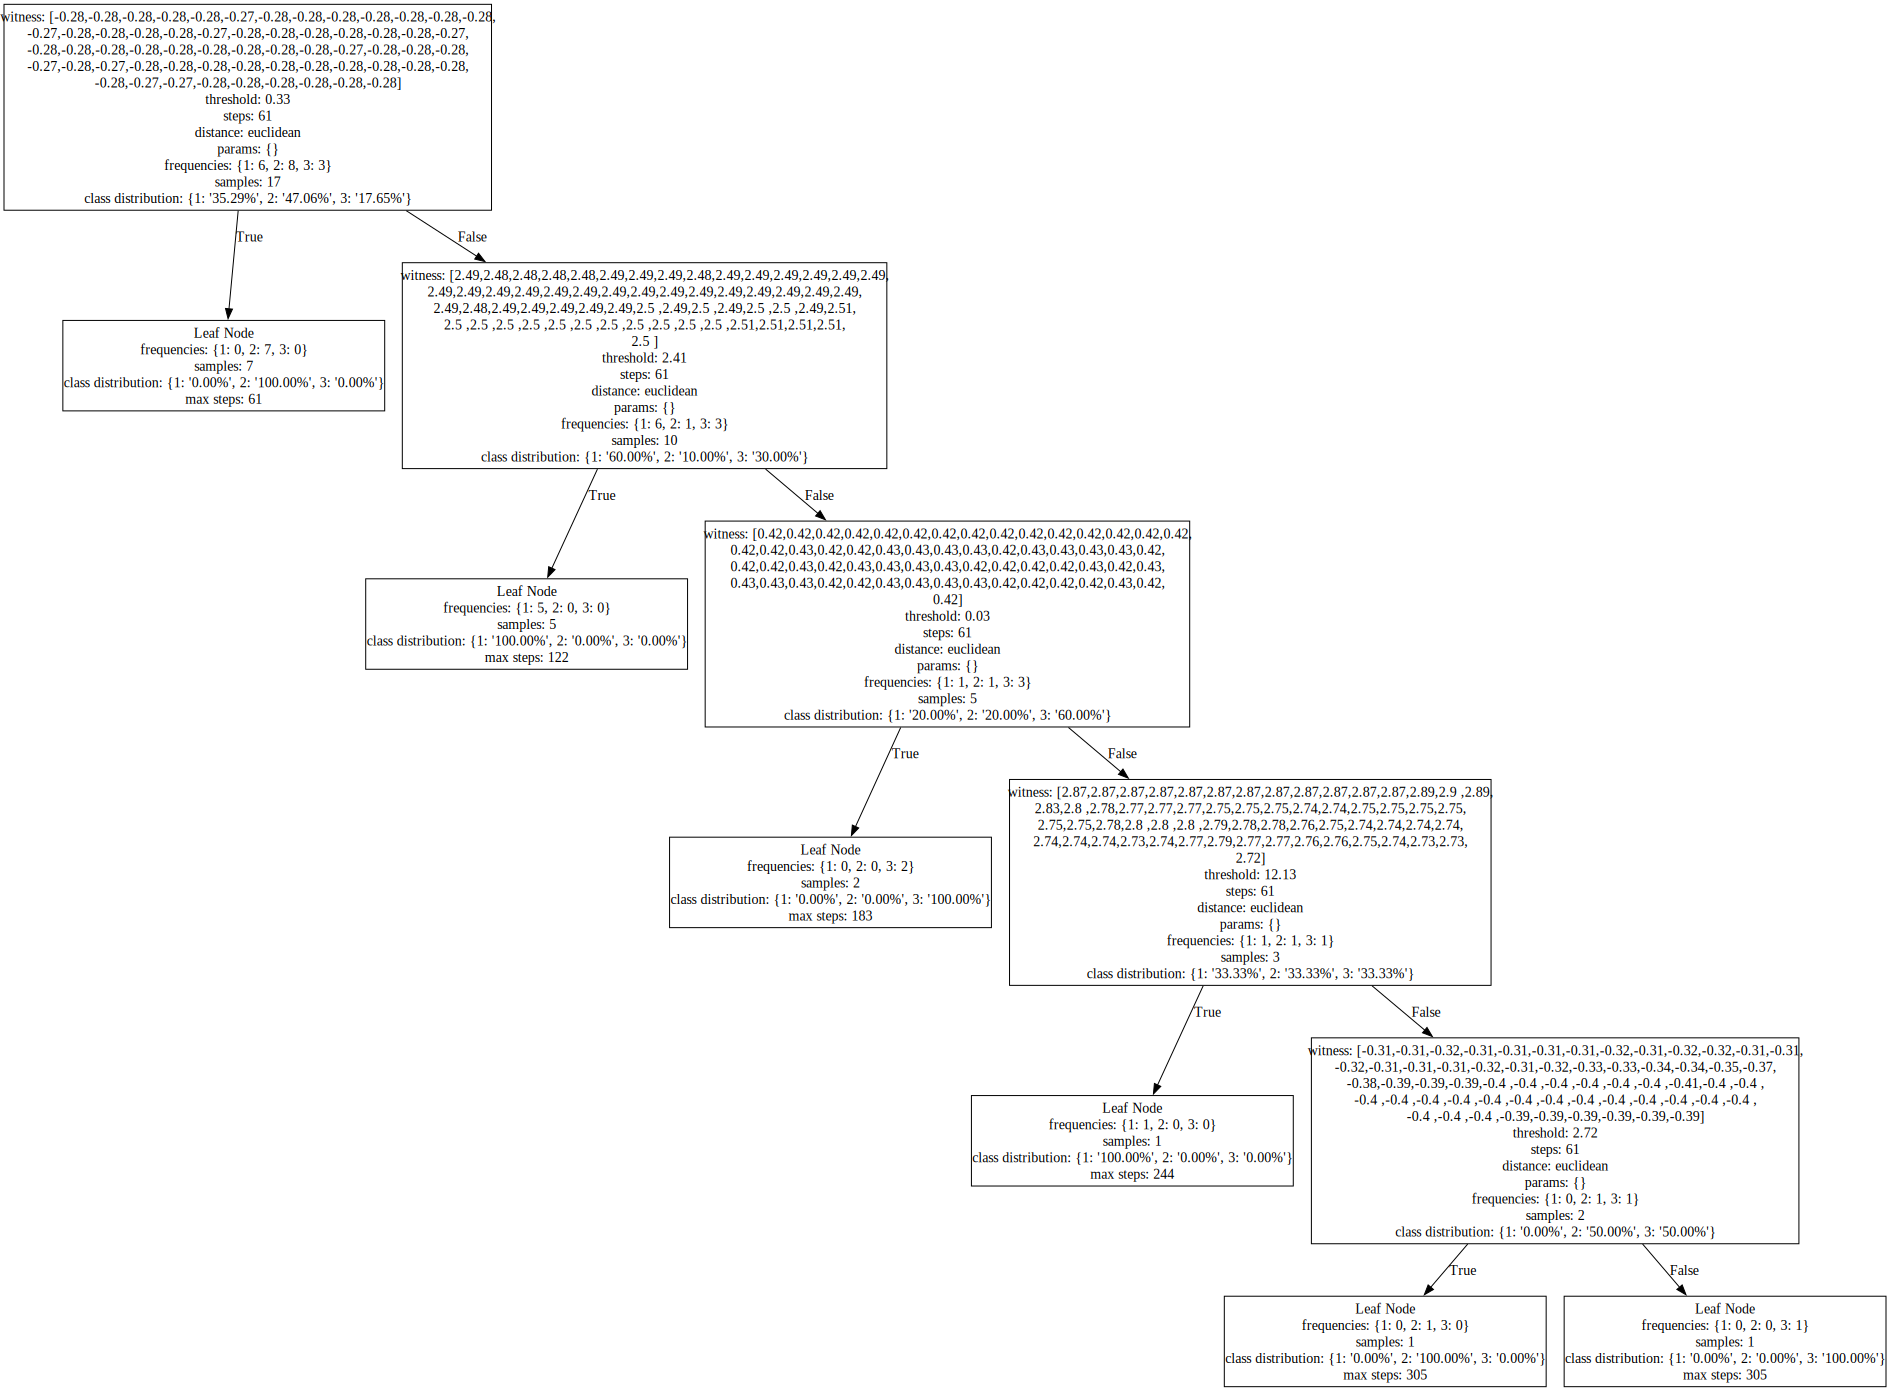

In [6]:
# select an index of a tree to visualize
dot = visualize_step_tree(rf.trees[0], all_classes) #rf.trees[0] shows the first tree in the forest
dot.render(f'{dataset}_ts_step_tree_rf', format='pdf', cleanup=True)
dot